In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')


In [187]:
test = pd.read_csv('./data/flight_delays_test.csv')
train = pd.read_csv('./data/flight_delays_train.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [188]:
df_combined = pd.concat(objs=(train, test), axis=0)

In [189]:
df_combined.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [190]:
df_combined.isnull().sum()

Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
UniqueCarrier             0
Origin                    0
Dest                      0
Distance                  0
dep_delayed_15min    100000
dtype: int64

In [191]:
df_combined.describe().T

,count,mean,std,min,25%,50%,75%,max
DepTime,200000.0,1340.230240,478.471381,1.0,930.0,1329.0,1733.0,2534.0
Distance,200000.0,726.263635,568.955768,30.0,319.0,575.0,954.0,4962.0


In [192]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              200000 non-null  object
 1   DayofMonth         200000 non-null  object
 2   DayOfWeek          200000 non-null  object
 3   DepTime            200000 non-null  int64 
 4   UniqueCarrier      200000 non-null  object
 5   Origin             200000 non-null  object
 6   Dest               200000 non-null  object
 7   Distance           200000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 15.3+ MB


In [193]:
df_clean = df_combined.copy()

df_clean['Month'] = df_clean['Month'].map(lambda val: val.split('-')[1]).astype(int)
df_clean['DayofMonth'] = df_clean['DayofMonth'].map(lambda val: val.split('-')[1]).astype(int)
df_clean['DayOfWeek'] = df_clean['DayOfWeek'].map(lambda val: val.split('-')[1]).astype(int)

def get_hour_minute(number: int) -> str | None:
    if not isinstance(number, int):
        return np.nan
    
    hour = number // 100
    minute = number % 100
    
    return hour, minute

df_clean[['DepHour', 'DepMinute']] = df_clean['DepTime'].apply(lambda x: pd.Series(get_hour_minute(x)))


In [194]:
df_clean.drop('DepTime', axis=1, inplace=True)

In [195]:
df_clean.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepHour,DepMinute
0,8,21,7,AA,ATL,DFW,732,N,19,34
1,4,20,3,US,PIT,MCO,834,N,15,48
2,9,2,5,XE,RDU,CLE,416,N,14,22
3,11,25,6,OO,DEN,MEM,872,N,10,15
4,10,7,6,WN,MDW,OMA,423,Y,18,28


In [196]:
df_clean['dep_delayed_15min'] = df_clean['dep_delayed_15min'].map({'N':0, 'Y':1})

In [197]:
df_clean.groupby('Origin')['dep_delayed_15min'].sum()

Origin
ABE     8.0
ABI     5.0
ABQ    78.0
ABY     3.0
ACK     1.0
       ... 
WYS     0.0
XNA    33.0
YAK     2.0
YKM     0.0
YUM     6.0
Name: dep_delayed_15min, Length: 307, dtype: float64

In [198]:
condition = df_clean['dep_delayed_15min'].notna()

df_delays = df_clean.loc[condition].groupby(['Origin','Month', 'DayofMonth'])['dep_delayed_15min'].sum()
delayed_days = df_delays[df_delays >= 2].index
    
def mark_delayed(row):
    if (row['Origin'], row['Month'], row['DayofMonth']) in delayed_days:
        return 1
    else: 
        return 0
    
df_clean['delayed_flag'] = df_clean.apply(mark_delayed, axis=1)

In [199]:
df_clean.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepHour,DepMinute,delayed_flag
0,8,21,7,AA,ATL,DFW,732,0.0,19,34,1
1,4,20,3,US,PIT,MCO,834,0.0,15,48,0
2,9,2,5,XE,RDU,CLE,416,0.0,14,22,0
3,11,25,6,OO,DEN,MEM,872,0.0,10,15,0
4,10,7,6,WN,MDW,OMA,423,1.0,18,28,0


In [200]:
num_features = df_clean.select_dtypes(include=[np.number]).columns
cal_features = df_clean.select_dtypes(include=[object]).columns


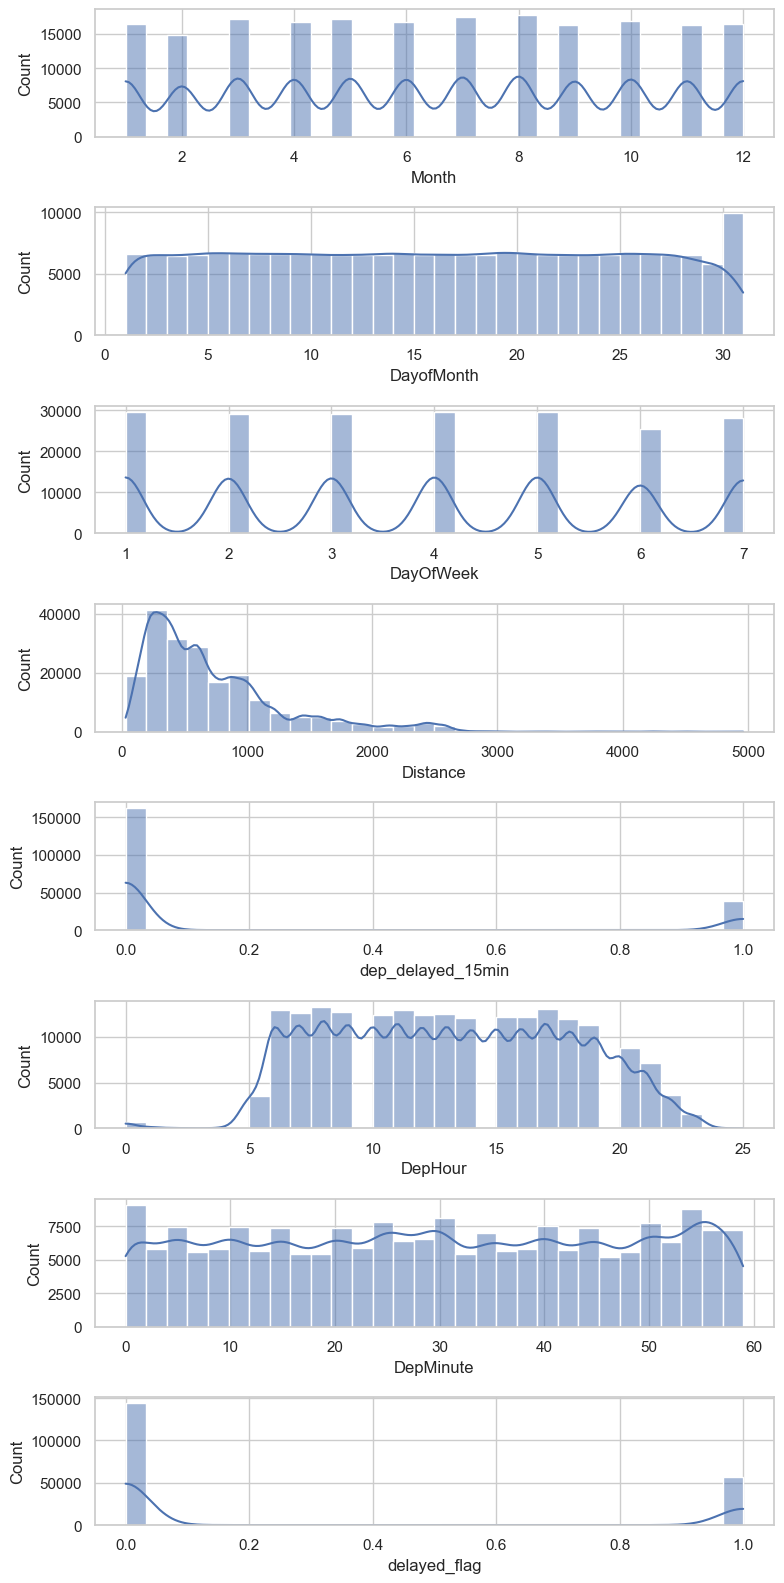

In [201]:
fig, ax = plt.subplots(nrows = len(num_features), ncols=1, figsize=(8, 16))

for idx, col in enumerate(num_features):
    sns.histplot(data=df_clean,
                x = col,
                bins=30,
                kde = True,
                ax=ax[idx])

plt.tight_layout()

In [202]:
skewed_distance = df_clean['Distance'].skew()


In [203]:
from scipy.stats import boxcox
df_transformed = df_clean.copy()
df_transformed['Distance'] = df_transformed[['Distance']].apply(lambda val: boxcox(val)[0])

KeyboardInterrupt: 

In [ ]:
preprocessing_columns = num_features.difference(['delayed_flag', 'dep_delayed_15min'])
scaler = StandardScaler()
transformer = ColumnTransformer(
    transformers = [
        ('num', scaler, preprocessing_columns)
    ],
    remainder='passthrough'
)

X = transformer.fit_transform(df_transformed)

df_scaled = pd.DataFrame(data = X,
                         columns = transformer.get_feature_names_out())

df_scaled.columns = df_scaled.columns.map(lambda col: col.split('__')[1])
df_scaled[num_features] = df_scaled[num_features].astype(np.number)

c:\Users\PC\Desktop\github_Repos\delayed_flights\.venv\Lib\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


In [ ]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DayOfWeek          200000 non-null  float64
 1   DayofMonth         200000 non-null  float64
 2   DepHour            200000 non-null  float64
 3   DepMinute          200000 non-null  float64
 4   Distance           200000 non-null  float64
 5   Month              200000 non-null  float64
 6   UniqueCarrier      200000 non-null  object 
 7   Origin             200000 non-null  object 
 8   Dest               200000 non-null  object 
 9   dep_delayed_15min  100000 non-null  float64
 10  delayed_flag       200000 non-null  float64
dtypes: float64(8), object(3)
memory usage: 16.8+ MB


In [ ]:
df_onehot = pd.get_dummies(df_scaled, columns=cal_features, drop_first=True, dtype=int)

In [ ]:
train_df = df_onehot[df_onehot['dep_delayed_15min'].notna()]
test_df = df_onehot[~df_onehot['dep_delayed_15min'].notna()]

In [ ]:
train_df.head()

,DayOfWeek,DayofMonth,DepHour,DepMinute,Distance,Month,dep_delayed_15min,delayed_flag,UniqueCarrier_AA,UniqueCarrier_AQ,...,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
0,1.535476,0.602520,1.230014,0.243291,0.347492,0.430226,0.0,1.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.473097,0.488782,0.395350,1.034619,0.520776,-0.741023,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.531190,-1.558512,0.186684,-0.434989,-0.379898,0.723039,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.033333,1.057474,-0.647980,-0.830653,0.580433,1.308664,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.033333,-0.989819,1.021348,-0.095849,-0.358948,1.015851,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = train_df.drop('dep_delayed_15min', axis=1)
y = train_df['dep_delayed_15min']

In [ ]:
pca = PCA(n_components=150)

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=RANDOM_STATE, stratify=y)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

models = dict(
    log_reg = LogisticRegression(),
    catboost=CatBoostClassifier(),
    xgb= XGBClassifier()
)

param_grid = {
    'log_reg': {
        'C': [0.0001, 0.01, 0.1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    },
    
    'catboost': {
        'iterations': [100, 300, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'depth': [4, 6, 8],
        'verbose': [0]
    },
    
    'xgb': {
        'objective': ['binary:logistic'],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
    }

}

results = {}

rsf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
for model_name, model in models.items():
    print(f'Tuning model.. {model_name}')
    rsearch = RandomizedSearchCV(estimator=model,
                                 param_distributions=param_grid[model_name],
                                 cv=rsf,
                                 verbose = 0,
                                 scoring='roc_auc',
                                 n_iter=10,
                                 n_jobs=-1,
                                 random_state=RANDOM_STATE
                                )
    
    rsearch.fit(X_train_reduced, y_train)
    best_params = rsearch.best_params_
    
    model.set_params(**best_params)
    model.fit(X_train_reduced, y_train)
    y_pred_train = model.predict(X_test_reduced)
    
    if hasattr(model, "predict_proba"):
        y_pred_train = model.predict_proba(X_test_reduced)[:, 1] 
    else:
        y_pred_train = model.decision_function(X_test_reduced)
    auc_score = roc_auc_score(y_test, y_pred_train)
    
    results[model_name] = {
        'best_params': best_params,
        'auc_score': auc_score,
    }
    
    print(f'Model {model_name}, auc_score: {auc_score}')


Tuning model.. log_reg
Model log_reg, auc_score: 0.7724011258649637
Tuning model.. catboost
Model catboost, auc_score: 0.7867478761384793
Tuning model.. xgb
Model xgb, auc_score: 0.7835740179515439


In [221]:
best_auc_score = max(map(lambda model_result: model_result['auc_score'], results.values()))
best_model = [model_name for model_name, model_result in results.items() if model_result['auc_score'] == best_auc_score]

In [222]:
estimator = models[best_model[0]]

In [263]:
X_test = test_df.drop('dep_delayed_15min', axis=1)
X_test_reduced = pca.transform(X_test)

y_pred = estimator.predict_proba(X_test_reduced)[:, 1]

In [272]:
result = pd.DataFrame({
    'dep_delayed_15min': y_pred
})

In [274]:
result.to_csv('submission.csv', index=False)